In [0]:
!pip install kmodes

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, AffinityPropagation
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE
from sklearn.preprocessing import PolynomialFeatures
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

pd.plotting.register_matplotlib_converters()
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
sns.set()

import warnings
warnings.filterwarnings("ignore")
import pickle

# Classes and Functions

In [0]:
class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features

    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]

        sc = StandardScaler()
        X = sc.fit_transform(X)

        pca = PCA(n_components=self.q).fit(X)
        A_q = pca.components_.T

        kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_

        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))

        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]

In [0]:
def silhouette_graph(data, cluster_number, model_labels):

  range_n_clusters = [cluster_number]

  for n_clusters in range_n_clusters:
      # Create plot
      fig, (ax1) = plt.subplots(1, 1)
      fig.set_size_inches(24, 7)

      ax1.set_xlim([-0.1, 1])
      ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

      # Cluster labels and silhouette score
      cluster_labels = model_labels
      silhouette_avg = silhouette_score(data, cluster_labels)
      print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

      # Silhouette scores for each sample
      sample_silhouette_values = silhouette_samples(data, cluster_labels)

      y_lower = 10
      for i in range(n_clusters):
          ith_cluster_silhouette_values = \
              sample_silhouette_values[cluster_labels == i]

          ith_cluster_silhouette_values.sort()

          size_cluster_i = ith_cluster_silhouette_values.shape[0]
          y_upper = y_lower + size_cluster_i

          color = cm.get_cmap("Spectral")(float(i) / n_clusters)
          ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

          ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

          y_lower = y_upper + 10

      ax1.set_title("The silhouette plot for the various clusters.")
      ax1.set_xlabel("The silhouette coefficient values")
      ax1.set_ylabel("Cluster label")

      ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

      ax1.set_yticks([])
      ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


      plt.show()
    

# Read Ratio Data

In [0]:
ratio_data = pd.read_csv('.../ratios_iqr.csv', index_col=0)

In [0]:
ratio_data.reset_index(drop=True, inplace=True)
print(ratio_data.shape)
ratio_data.head(3)

(41949, 19)


,Company Code,Issuer Rating,Country of Headquarters,TRBC Industry Group Name,Company Name,current_ratio,nwc_to_sales,cash_conversion_cycle,debt_to_asset,debt_to_equity,net_debt_to_ebit,gross_profit_margin,ebitda_margin,ebit_margin,net_profit_margin,roic,roe,roa,asset_turnover_rate
0,WMT,NaN,United States of America,Food & Drug Retailing,Walmart Inc,0.79,0.01,3.02,0.24,0.77,2.12,0.25,0.06,0.04,0.03,0.13,0.19,0.06,2.26
1,WMT,NaN,United States of America,Food & Drug Retailing,Walmart Inc,0.82,0.01,3.11,0.24,0.76,2.00,0.25,0.06,0.04,0.02,0.13,0.13,0.04,2.33
2,WMT,NaN,United States of America,Food & Drug Retailing,Walmart Inc,0.81,0.01,2.75,0.24,0.70,1.86,0.25,0.06,0.04,0.01,0.13,0.10,0.03,2.40


In [0]:
#Performances and results of the models will be tested later with Turkish firm examples from different industries
ratio_data_try = ratio_data.copy()
selected_turkish_firms = [
                          'ASELS.IS', 'CCOLA.IS', 'GUBRF.IS', 'VESTL.IS', 'ENKAI.IS', 'CIMSA.IS', 'TATGD.IS', 'ULKER.IS', 'KUTPO.IS',
                          'KLMSN.IS', 'SANEL.IS', 'DOBUR.IS', 'EREGL.IS', 'CEMTS.IS', 'TUPRS.IS', 'THYAO.IS', 'PGSUS.IS', 'TCELL.IS',
                          'DESA.IS', 'YUNSA.IS'
]

# Principal Feature Analysis

PFA (with correlogram) is used to select features

In [0]:
pfa_data = ratio_data[[
                       'current_ratio','nwc_to_sales', 'cash_conversion_cycle', 'debt_to_asset', 'ebit_margin', 'roic', 'roa', 'asset_turnover_rate',
                       'net_debt_to_ebit'
]]

In [0]:
pfa = PFA(n_features=6)
pfa.fit(pfa_data)
[list(pfa_data.columns)[i] for i in pfa.indices_]

['current_ratio',
 'nwc_to_sales',
 'cash_conversion_cycle',
 'debt_to_asset',
 'ebit_margin',
 'asset_turnover_rate']

In [0]:
#Selected features
ratio_data2 = ratio_data[[
                       'current_ratio','nwc_to_sales', 'debt_to_asset', 'ebit_margin', 'roic','net_debt_to_ebit'
]]

In [0]:
ratio_data2.describe()

,current_ratio,nwc_to_sales,debt_to_asset,ebit_margin,roic,net_debt_to_ebit
count,"41,949.00","41,949.00","41,949.00","41,949.00","41,949.00","41,949.00"
mean,2.10,0.23,0.18,0.09,0.08,1.18
std,1.26,0.18,0.15,0.08,0.06,5.12
min,0.11,-0.52,0.00,-0.28,-0.20,-18.33
25%,1.26,0.11,0.05,0.04,0.04,-1.61
50%,1.74,0.21,0.17,0.08,0.07,0.73
75%,2.57,0.32,0.29,0.13,0.11,3.56
max,7.44,1.02,0.72,0.44,0.33,20.96


# Scaling

In [0]:
sc = StandardScaler()
ratio_sc = sc.fit_transform(ratio_data2)

# KMeans

### Elbow Curve

In [0]:
score = []
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, random_state = 23)
    kmeans.fit(ratio_sc)
    score.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow curve')

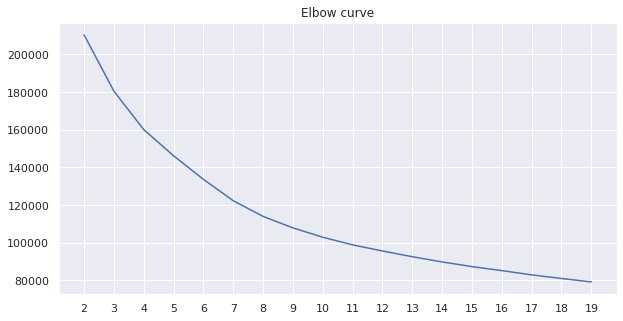

In [0]:
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, 20), score)
plt.xticks(range(2, 20), range(2, 20))
plt.grid(True)
plt.title('Elbow curve')

### Model

In [0]:
kmeans = KMeans(n_clusters=8, random_state = 0)
kmeans.fit(ratio_sc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

### Model Results

In [0]:
#Cluster Centers
df_centers = pd.DataFrame(kmeans.cluster_centers_, index = ['Cluster_' + str(i) for i in range(8)])
df_centers.columns = ratio_data2.columns

df_centers

,current_ratio,nwc_to_sales,debt_to_asset,ebit_margin,roic,asset_turnover_rate,net_debt_to_ebit
Cluster_0,0.21,-0.24,-0.67,1.10,1.87,0.19,-0.40
Cluster_1,-0.64,-0.16,1.13,-0.48,-0.50,-0.07,1.14
Cluster_2,2.17,0.45,-1.00,0.53,0.00,-0.49,-1.06
Cluster_3,-0.06,1.83,0.20,0.24,-0.30,-0.75,0.21
Cluster_4,0.55,-0.03,-0.72,-2.16,-2.28,-0.18,0.90
Cluster_5,-0.02,-0.20,-0.61,-0.28,-0.18,-0.07,-0.65
Cluster_6,-0.42,-0.70,-0.10,-0.64,0.28,1.87,-0.16
Cluster_7,-0.57,-0.43,0.91,1.15,0.29,-0.77,0.33


In [0]:
#Cluster sizes
ratio_cs_df = pd.DataFrame(ratio_sc, columns=ratio_data2.columns)
ratio_cs_df['label'] = kmeans.labels_.reshape(-1,1)

ratio_cs_df['label'].value_counts()

5    8792
1    7297
6    4709
7    4320
3    4042
0    3758
2    3689
4    1394
Name: label, dtype: int64

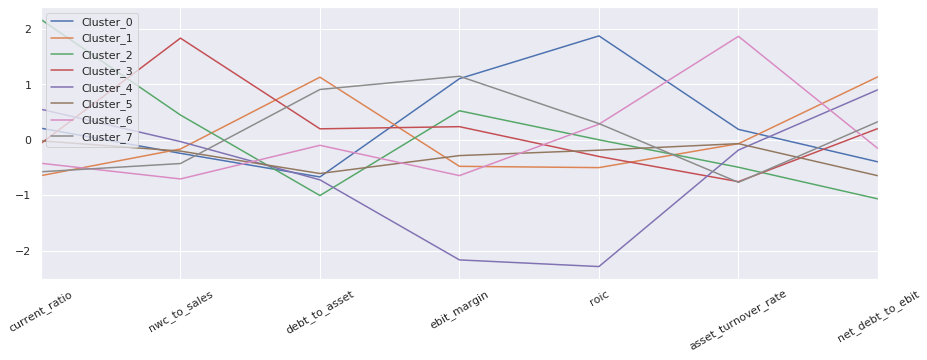

In [0]:
#Cluster center plot
df_centers.transpose().plot(figsize=(15,5))
plt.xticks(rotation=30)
plt.show()

For n_clusters = 8 The average silhouette_score is : 0.194722393627447


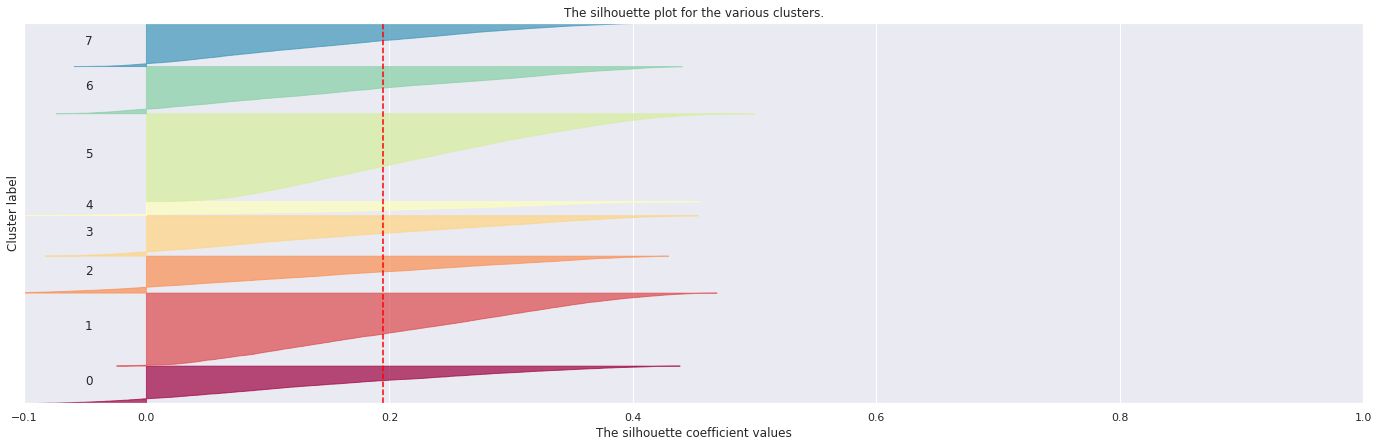

In [0]:
#Silhouette Graph & Score
silhouette_graph(data=ratio_sc,cluster_number=8, model_labels=kmeans.labels_)

# Agglomerative Clustering

### Dendrogram

In [0]:
ratio_sample = pd.DataFrame(ratio_sc).sample(frac = 0.20, random_state=23)

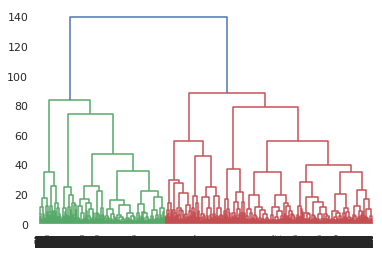

In [0]:
Z = hierarchy.linkage(ratio_sample, 'ward')
plt.figure()
dn = hierarchy.dendrogram(Z)

### Silhouette Score Graph

1
2
3
4
5
6
7
8
9
10


Text(0.5, 1.0, 'Elbow curve')

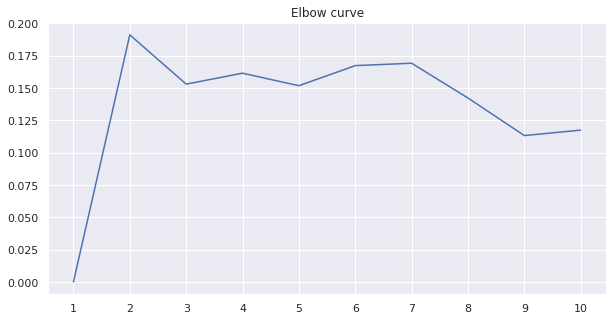

In [0]:
score = []
for i in range(1, 11):
    print(i)
    if i == 1:
      score.append(0)
    else:
      agg = AgglomerativeClustering(n_clusters = i, affinity = 'euclidean', linkage = 'ward')
      agg.fit(ratio_sample)
      silhouette_avg = silhouette_score(ratio_sample, agg.labels_)
      score.append(silhouette_avg)

fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), score)
plt.xticks(range(1, 11), range(1, 11))
plt.grid(True)
plt.title('Elbow curve')

### Model

In [0]:
agg = AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage = 'ward')
agg.fit(ratio_sc)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=6,
                        pooling_func='deprecated')

### Model Results

In [0]:
#Cluster Centers
ratio_cs_df = pd.DataFrame(ratio_sc, columns=ratio_data2.columns)
ratio_cs_df['label'] = agg.labels_.reshape(-1,1)

In [0]:
df_centers = ratio_cs_df.groupby('label').mean()
df_centers

,current_ratio,nwc_to_sales,debt_to_asset,ebit_margin,roic,net_debt_to_ebit
label,,,,,,
0,-0.61,-0.20,0.99,-0.19,-0.19,0.80
1,0.14,-0.17,-0.56,0.98,1.11,-0.40
2,0.01,1.19,0.04,0.17,-0.14,-0.10
3,-0.18,-0.55,-0.59,-0.57,-0.31,-0.77
4,2.09,0.26,-0.94,0.24,-0.02,-0.98
5,0.37,0.01,-0.56,-1.87,-1.96,1.08


In [0]:
#Cluster Sizes
ratio_cs_df['label'].value_counts()

0    13817
1     8997
3     7237
2     6168
4     3616
5     2114
Name: label, dtype: int64

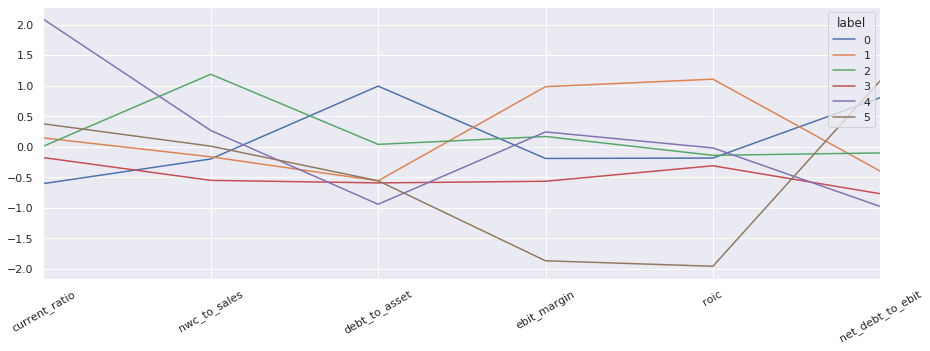

In [0]:
#Cluster Center Plot
df_centers.transpose().plot(figsize=(15,5))
plt.xticks(rotation=30)
plt.show()

For n_clusters = 6 The average silhouette_score is : 0.1407589799717837


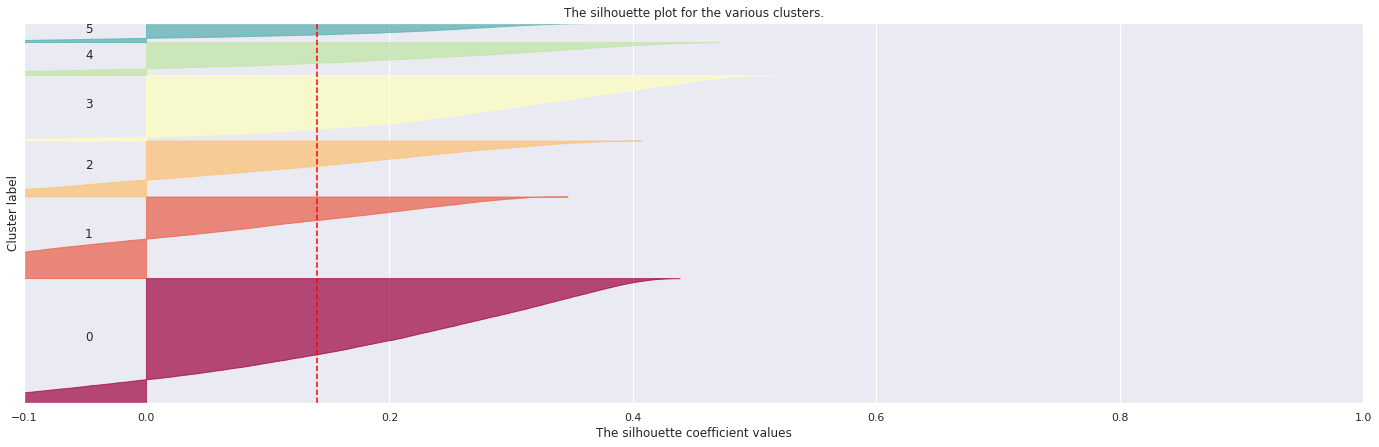

In [0]:
#Silhouette Graph and Score
silhouette_graph(data=ratio_sc,cluster_number=6, model_labels=agg.labels_)

In [0]:
#Rating Labels of Clusters
#Rating labels are given to the clusters by their cluster centers with considering
#importance of financial ratios and effects of these ratios on financial performance and default risk
ratio_data_try['label'] = agg.labels_
ratio_data_try['rating'] = ['AAA-AA' if x==1 else 'A-BBB' if x==4 else 'BB' if x==2 else 'B' if x==3 else 'CCC' if x==0 else 'CC-C' for x in ratio_data_try['label']]

In [0]:
#Ratings of selected Turkish firms
ratio_data_try2 = ratio_data_try[ratio_data_try['Company Code'].isin(selected_turkish_firms)]
ratio_data_try2 = ratio_data_try2.groupby('Company Code').first()

ratio_data_try2 = ratio_data_try2[['rating','TRBC Industry Group Name',
       'Company Name', 'current_ratio', 'nwc_to_sales',
       'debt_to_asset','net_debt_to_ebit','ebit_margin','roic']]

ratio_data_try2

,rating,TRBC Industry Group Name,Company Name,current_ratio,nwc_to_sales,debt_to_asset,net_debt_to_ebit,ebit_margin,roic
Company Code,,,,,,,,,
ASELS.IS,AAA-AA,Aerospace & Defense,Aselsan Elektronik Sanayi ve Ticaret AS,2.48,0.45,0.05,-0.80,0.19,0.13
CCOLA.IS,CCC,Beverages,Coca-Cola Icecek AS,1.43,0.05,0.37,2.30,0.12,0.09
CEMTS.IS,AAA-AA,Metals & Mining,Cemtas Celik Makina Sanayi ve Ticaret AS,4.17,0.34,0.07,-0.05,0.15,0.20
CIMSA.IS,CCC,Construction Materials,Cimsa Cimento Sanayi ve Ticaret AS,0.72,0.25,0.44,8.07,0.11,0.05
DESA.IS,CCC,Textiles & Apparel,Desa Deri Sanayi ve Ticaret AS,1.14,0.23,0.33,2.30,0.12,0.19
DOBUR.IS,B,Media & Publishing,Dogan Burda Dergi Yayincilik ve Pazarlama AS,2.25,0.18,0.00,-4.83,0.05,0.13
ENKAI.IS,AAA-AA,Construction & Engineering,ENKA Insaat ve Sanayi AS,2.88,0.18,0.03,-2.72,0.20,0.06
EREGL.IS,BB,Metals & Mining,Eregli Demir ve Celik Fabrikalari TAS,2.47,0.39,0.14,-0.39,0.24,0.16
GUBRF.IS,CCC,Chemicals,Gubre Fabrikalari TAS,0.89,0.13,0.33,1.50,0.13,0.22


# Gaussian Mixture

### Model

In [0]:
gmm = GaussianMixture(n_components=5, random_state = 0)
gmm.fit(ratio_sc)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [0]:
gmm_labels = gmm.predict(ratio_sc)

### Model Results

In [0]:
#Cluster Centers
ratio_cs_df = pd.DataFrame(ratio_sc, columns=ratio_data2.columns)
ratio_cs_df['label'] = gmm_labels.reshape(-1,1)

In [0]:
df_centers = ratio_cs_df.groupby('label').mean()
df_centers

,current_ratio,nwc_to_sales,debt_to_asset,ebit_margin,roic,asset_turnover_rate,net_debt_to_ebit
label,,,,,,,
0,1.19,0.09,-1.09,0.20,0.18,-0.18,-0.91
1,0.56,0.06,-0.23,-1.18,-1.40,-0.23,0.24
2,-0.38,-0.52,0.03,-0.59,0.09,1.17,-0.06
3,-0.04,0.16,0.11,1.22,0.79,-0.54,-0.04
4,-0.48,0.27,0.58,-0.24,-0.40,-0.42,0.53


In [0]:
#Cluster Sizes
ratio_cs_df['label'].value_counts()

4    10390
2     9442
3     8866
0     5931
1     3372
Name: label, dtype: int64

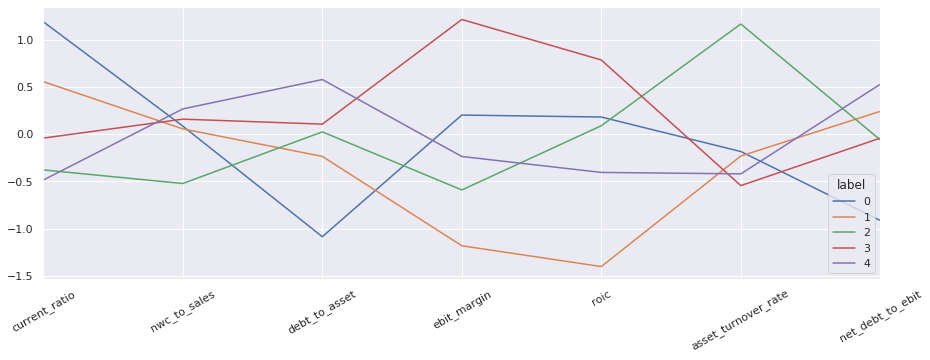

In [0]:
#Cluster Center Plot
df_centers.transpose().plot(figsize=(15,5))
plt.xticks(rotation=30)
plt.show()

For n_clusters = 5 The average silhouette_score is : 0.10470856793407189


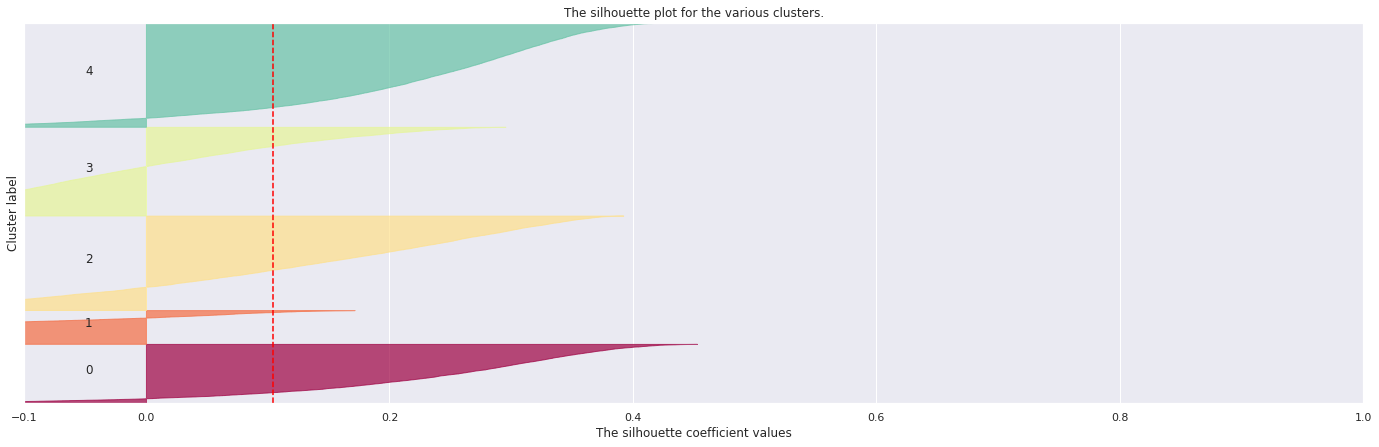

In [0]:
#Silhouette Graph and Score
silhouette_graph(data = ratio_sc, cluster_number=5, model_labels=gmm_labels)

# K Prototype

### Data Preperation for KPrototype Model

In [0]:
ratio_data3 = ratio_data[[
                       'TRBC Industry Group Name',
                       'current_ratio','nwc_to_sales', 'debt_to_asset', 'ebit_margin', 'roic', 'net_debt_to_ebit'
]]

In [0]:
sc = StandardScaler()
ratio_sc2 = sc.fit_transform(ratio_data3.iloc[:,1:])

In [0]:
ratio_sc2 = pd.DataFrame(ratio_sc2, columns=ratio_data3.columns[1:])
ratio_sc2['TRBC Industry Group Name'] = ratio_data3['TRBC Industry Group Name']

### Silhouette Score Graph

In [0]:
ratio_sample = ratio_sc2.sample(frac = 0.10, random_state=23)

1
2
3
4
5
6
7
8
9
10


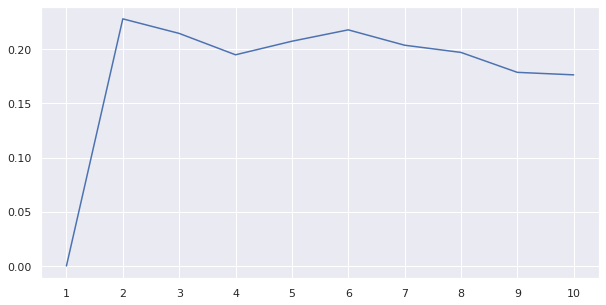

In [0]:
score = []
for i in range(1, 11):
    print(i)
    if i == 1:
      score.append(0)
    else:
      kp = KPrototypes(n_clusters=i, init='Huang')
      kp_labels = kp.fit_predict(ratio_sample, categorical=[6])
      silhouette_avg = silhouette_score(ratio_sample.iloc[:,:6], kp_labels)
      score.append(silhouette_avg)

fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), score)
plt.xticks(range(1, 11), range(1, 11))
plt.grid(True)
#plt.title('Elbow curve')

### Model

In [0]:
start_time = time.time()
kp = KPrototypes(n_clusters=6, init='Huang')
kp_labels = kp.fit_predict(ratio_sc2, categorical=[6])
elapsed_time = time.time() - start_time
print(elapsed_time)

808.6983408927917


### Model Results

In [0]:
#Cluster Centers
ratio_sc2['label'] = kp_labels.reshape(-1,1)

df_centers = ratio_sc2.groupby('label').mean()
df_centers

,current_ratio,nwc_to_sales,debt_to_asset,ebit_margin,roic,net_debt_to_ebit
label,,,,,,
0,-0.10,1.68,0.29,0.21,-0.23,0.21
1,0.50,-0.03,-0.69,-1.97,-2.06,0.87
2,2.02,0.42,-1.00,0.44,0.05,-1.04
3,-0.65,-0.35,1.14,-0.20,-0.34,0.97
4,-0.07,-0.31,-0.28,1.19,1.57,-0.28
5,-0.18,-0.39,-0.53,-0.37,-0.08,-0.56


In [0]:
#Cluster Sizes
ratio_sc2['label'].value_counts()

5    12457
3    11368
4     6256
0     5174
2     4808
1     1886
Name: label, dtype: int64

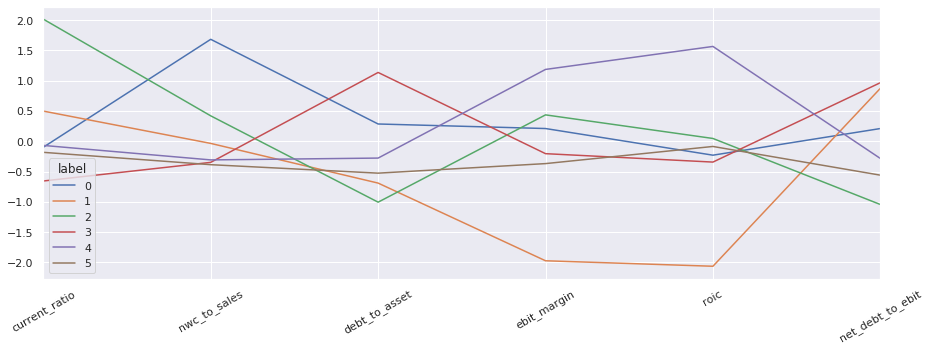

In [0]:
#Cluster Center Plot
df_centers.transpose().plot(figsize=(15,5))
plt.xticks(rotation=30)
plt.show()

For n_clusters = 6 The average silhouette_score is : 0.22283417342120074


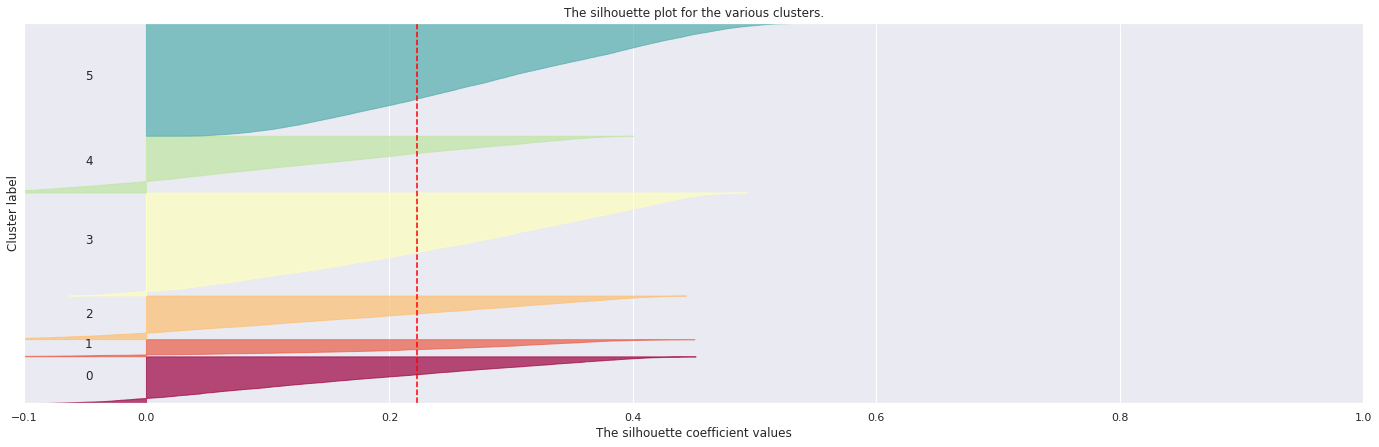

In [0]:
#Silhouette Graph and Score
silhouette_graph(data=ratio_sc2.iloc[:,:6],cluster_number=6, model_labels=kp_labels)

In [0]:
#Rating Labels of Clusters
#Rating labels are given to the clusters by their cluster centers with considering
#importance of financial ratios and effects of these ratios on financial performance and default risk
ratio_data_try['label'] = kp_labels
ratio_data_try['rating'] = ['AAA-AA' if x==4 else 'A-BBB' if x==2 else 'BB' if x==5 else 'B' if x==0 else 'CCC' if x==3 else 'CC-C' for x in ratio_data_try['label']]

In [0]:
#Ratings of selected Turkish firms
ratio_data_try2 = ratio_data_try[ratio_data_try['Company Code'].isin(selected_turkish_firms)]
ratio_data_try2 = ratio_data_try2.groupby('Company Code').first()

ratio_data_try2 = ratio_data_try2[['rating','TRBC Industry Group Name',
       'Company Name', 'current_ratio', 'nwc_to_sales',
       'debt_to_asset','net_debt_to_ebit','ebit_margin','roic']]

ratio_data_try2

,rating,TRBC Industry Group Name,Company Name,current_ratio,nwc_to_sales,debt_to_asset,net_debt_to_ebit,ebit_margin,roic
Company Code,,,,,,,,,
ASELS.IS,AAA-AA,Aerospace & Defense,Aselsan Elektronik Sanayi ve Ticaret AS,2.48,0.45,0.05,-0.80,0.19,0.13
CCOLA.IS,CCC,Beverages,Coca-Cola Icecek AS,1.43,0.05,0.37,2.30,0.12,0.09
CEMTS.IS,AAA-AA,Metals & Mining,Cemtas Celik Makina Sanayi ve Ticaret AS,4.17,0.34,0.07,-0.05,0.15,0.20
CIMSA.IS,CCC,Construction Materials,Cimsa Cimento Sanayi ve Ticaret AS,0.72,0.25,0.44,8.07,0.11,0.05
DESA.IS,AAA-AA,Textiles & Apparel,Desa Deri Sanayi ve Ticaret AS,1.14,0.23,0.33,2.30,0.12,0.19
DOBUR.IS,BB,Media & Publishing,Dogan Burda Dergi Yayincilik ve Pazarlama AS,2.25,0.18,0.00,-4.83,0.05,0.13
ENKAI.IS,A-BBB,Construction & Engineering,ENKA Insaat ve Sanayi AS,2.88,0.18,0.03,-2.72,0.20,0.06
EREGL.IS,AAA-AA,Metals & Mining,Eregli Demir ve Celik Fabrikalari TAS,2.47,0.39,0.14,-0.39,0.24,0.16
GUBRF.IS,AAA-AA,Chemicals,Gubre Fabrikalari TAS,0.89,0.13,0.33,1.50,0.13,0.22


# Private Company Tests of Selected Model (KPrototype)

In [0]:
#Private company tests are excluded from the code due to confidentiality issues (even if company names are masked).
#After analyzing predicted ratings of private company examples and public turkish firms,
#KPrototype model is selected as final model.

# Saving Trained Model

In [0]:
#Save trained model
with open('.../model_kp_all.pkl','wb') as f:
    pickle.dump(kp_labels,f)